#### Задача 9.1

In [234]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import numpy.linalg as la
from sklearn.metrics import mean_squared_error as msq

%matplotlib inline

In [235]:
#читаем данные, т.к. они разных типов genfromtext создает не очень
#удобный массив -> поэтому так
dataset = []
with open('forestfires.csv') as data_file:
    for line in data_file:
        dataset.append(line[:-1].split(','))
print(dataset[0])
#заголовки не нужны
dataset = dataset[1:]

['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']


In [236]:
#преобразуем месяцы
month_col = 2
for i in range(0, len(dataset)):
    if dataset[i][month_col] in ('jun', 'jul', 'aug'):
        dataset[i][month_col] = 1
    else: dataset[i][month_col] = 0
        
#меняем день недели на константу
day_col = 3
for i in range(0, len(dataset)):
    dataset[i][day_col] = 1
dataset = np.asarray(dataset, dtype=np.double)

In [237]:
def do_everything():
    #перемешиваем
    shuffled_data = np.copy(dataset)
    np.random.shuffle(shuffled_data)

    #делим на две части
    k = int(len(shuffled_data) * 0.7)
    train = shuffled_data[:k]
    test = shuffled_data[k:]
    
    #признаки
    train_x = train[:,:12]
    test_x = test[:,:12]
    #значения целевой переменной
    area_col = 12
    train_y = train[:,12]
    test_y = test[:,12]
            
    #обучаемся
    theta = np.dot(np.dot(la.inv(np.dot(train_x.T, train_x)), train_x.T), 
                   train_y)
    
    #тестируем на оставшейся части
    predictions = np.dot(test_x, theta)
    
    #среднеквадратичная ошибка
    return msq(predictions, test_y)

In [238]:
k = 5
for i in range(0, k):
    print(do_everything())

8354.7296793
774.770448888
867.839072538
480.331575752
1281.02267298


Сильно зависит от перемешивания. Не с чем сравнить, но кажется получилось много.

Делаем преобразование $area = log(area + c)$

In [239]:
def do_everything(const):
    #перемешиваем
    shuffled_data = np.copy(dataset)
    np.random.shuffle(shuffled_data)

    #делим на две части
    k = int(len(shuffled_data) * 0.7)
    train = shuffled_data[:k]
    test = shuffled_data[k:]
    
    #признаки
    train_x = train[:,:12]
    test_x = test[:,:12]
    #значения целевой переменной
    area_col = 12
    train_y = train[:,12]
    test_y = test[:,12]
    train_y_conv = np.log(train_y + const)
    test_y_conv = np.log(test_y + const)
            
    #обучаемся
    theta = np.dot(np.dot(la.inv(np.dot(train_x.T, train_x)), train_x.T), 
                   train_y_conv)
    
    #обратное преобразование к оценкам
    theta_ret = np.exp(theta) - const

    #тестируем на оставшейся части
    predictions_1 = np.dot(test_x, theta)
    predictions_2 = np.dot(test_x, theta_ret)
    
    #среднеквадратичная ошибка
    return (msq(predictions_1, test_y_conv), 
            msq(predictions_2, test_y))

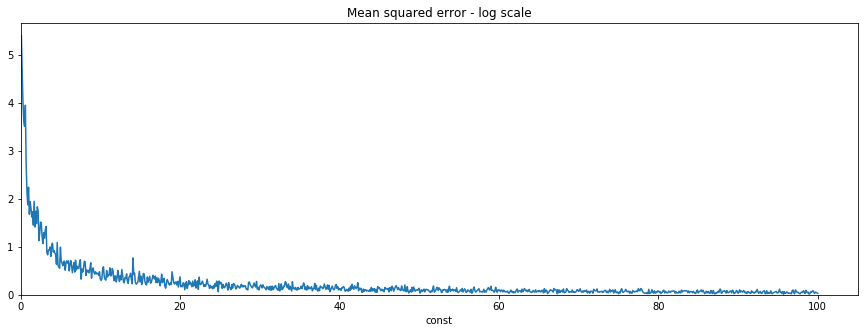

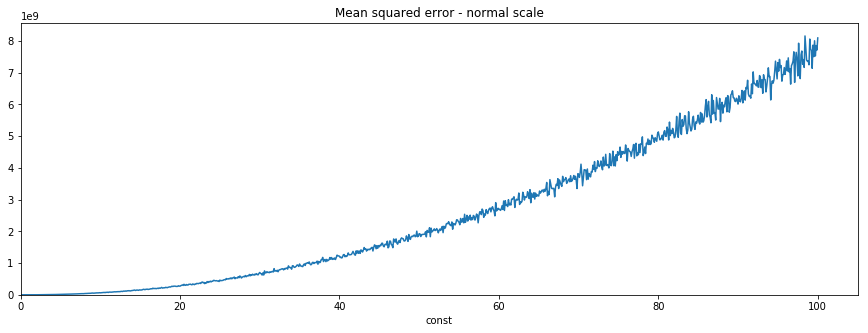

In [247]:
consts = np.linspace(0.1, 100, 1000)
errors = np.zeros((len(consts), 2))

#для всех констант ищем ошибки и находим сразу минимум
min_err = 0
for i in range(0, len(consts)):
    errors[i] = do_everything(consts[i])
    if (errors[i][1] < errors[min_err][1]):
        min_err = i

plt.figure(figsize=(15,5))
plt.plot(consts, errors[:,0])
plt.title("Mean squared error - log scale")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('const')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(consts, errors[:,1])
plt.title("Mean squared error - normal scale")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('const')
plt.show()

In [248]:
print("Предсказания лучше всего получаются при const =", consts[min_err])
print("При этом среднеквадратичная ошибка = ", errors[min_err][1])

Предсказания лучше всего получаются при const = 1.0
При этом среднеквадратичная ошибка =  688.430813959


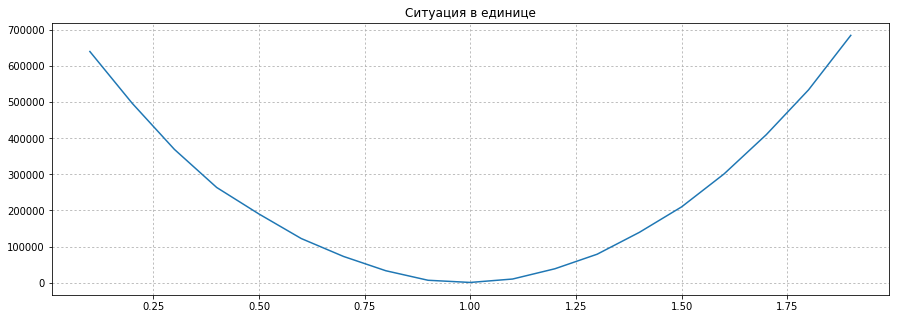

In [249]:
limit = 19
plt.figure(figsize=(15,5))
plt.plot(consts[:limit], errors[:limit,1])
plt.title("Ситуация в единице")
plt.grid(ls=':')
plt.show()

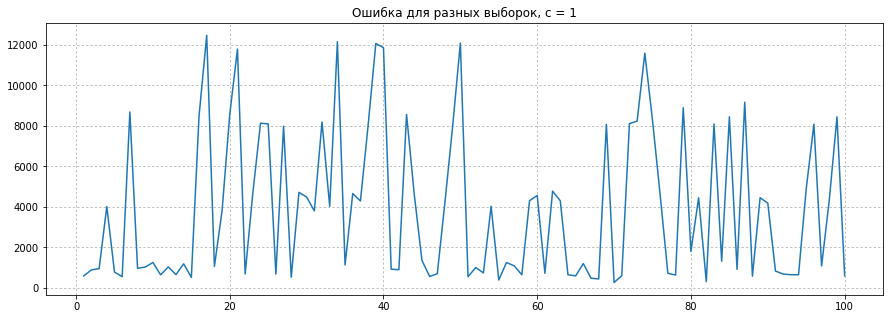

Разброс ошибок от 260.606015751 до 12479.457765


In [250]:
n = 100
errors = np.zeros(n)

for i in range(0, n):
    errors[i] = do_everything(1)[1]
        
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, n + 1), errors)
plt.title("Ошибка для разных выборок, c = 1")
plt.grid(ls=':')
plt.show()

print("Разброс ошибок от", errors.min(), "до", errors.max())

Результаты после логарифмирования не сильно отличаются, чем без него.

Оценивать у нас получается плохо. Возможно нам стоило лучше поработать над признаками / нормализовать их и т.д.